경고: 010010 데이터가 비어 있거나 '종가' 컬럼이 없습니다. 제외합니다.
price_data 내용: {'214450':                 종가      시가      고가      저가     거래량
날짜                                                
2022-01-03   82000   83000   83000   80800   36622
2022-01-04   79800   82000   82600   79600   53197
2022-01-05   78100   78700   79600   77700   61881
2022-01-06   77600   76700   78400   76700   48222
2022-01-07   78300   77700   79100   77700   30400
...            ...     ...     ...     ...     ...
2024-12-23  256500  256000  260000  249500   76157
2024-12-24  266500  256500  270000  254500  127616
2024-12-26  262500  269500  269500  256000  134001
2024-12-27  255500  262500  267500  252000  112048
2024-12-30  262500  254500  266500  253000   98520

[735 rows x 5 columns], '051900':                  종가       시가       고가       저가    거래량
날짜                                                   
2022-01-03  1104000  1109000  1109000  1093000  19072
2022-01-04  1102000  1093000  1115000  1093000  26830
2022-01-05  107

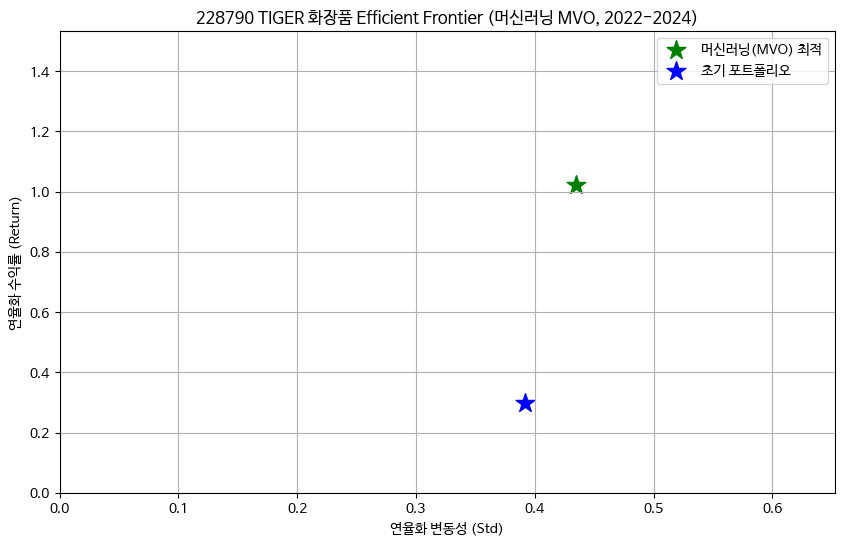

In [4]:
import pandas as pd
import numpy as np
from pykrx import stock
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 설정
start_date = "20220101"
end_date = "20241231"
etf_ticker = "228790"  # TIGER 화장품
risk_free_rate = 0.02
date = "20241010"

# 1. ETF 구성 종목과 비중 가져오기
portfolio = stock.get_etf_portfolio_deposit_file(etf_ticker, date)
valid_portfolio = portfolio[portfolio.index.str.match(r"^\d{6}$") & (portfolio["비중"] > 0)].copy()
initial_tickers = valid_portfolio.index.tolist()
initial_weights = valid_portfolio["비중"].values / 100

# 2. 종가 데이터 가져오기 (디버깅 추가)
price_data = {}
for ticker in initial_tickers:
    try:
        df = stock.get_market_ohlcv_by_date(start_date, end_date, ticker)
        if not df.empty and "종가" in df.columns:
            price_data[ticker] = df[["종가", "시가", "고가", "저가", "거래량"]]
        else:
            print(f"경고: {ticker} 데이터가 비어 있거나 '종가' 컬럼이 없습니다. 제외합니다.")
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
print("price_data 내용:", price_data)

# price_data를 DataFrame으로 변환 (각 종목 데이터는 열로)
prices = pd.concat([df for df in price_data.values()], axis=1, keys=price_data.keys()).dropna()
print("prices shape:", prices.shape)

# 3. 특징(feature) 및 타겟(target) 생성
features = []
targets = []
for ticker in prices.columns.levels[0]:  # 멀티인덱스 사용
    df = prices[ticker].reset_index()
    df["수익률"] = df["종가"].pct_change().shift(-1)  # 다음 날 수익률
    df = df.dropna()
    X = df[["종가", "시가", "고가", "저가", "거래량"]]  # 특징
    y = df["수익률"]  # 타겟
    features.append(X)
    targets.append(y)

# 4. 포트폴리오 성과 계산 함수
def portfolio_performance(weights, returns, risk_free_rate):
    portfolio_returns = returns.dot(weights)
    mean_return = portfolio_returns.mean() * 252
    portfolio_std = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = (mean_return - risk_free_rate) / portfolio_std
    return mean_return, portfolio_std, sharpe_ratio, portfolio_returns

# 4. 랜덤 포레스트로 수익률 예측
predicted_returns = {}
for i, ticker in enumerate(prices.columns.levels[0]):
    X = features[i]
    y = targets[i]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE 직접 계산
    print(f"{ticker} - RMSE: {rmse:.4f}")
    
    # 전체 데이터를 사용해 최종 예측
    final_pred = model.predict(X)
    predicted_returns[ticker] = final_pred.mean() * 252  # 연율화

# 5. 예측된 수익률로 MVO 수행
tickers = prices.columns.levels[0].tolist()
expected_returns = np.array([predicted_returns.get(ticker, 0) for ticker in tickers])
returns = prices.xs('종가', level=1, axis=1).pct_change().dropna()  # 종가 기반 수익률
cov_matrix = returns.cov() * 252  # 공분산 행렬 연율화

def neg_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate):
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -(portfolio_return - risk_free_rate) / portfolio_std

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = tuple((0, 0.2) for _ in range(len(tickers)))  # 상한 20%
initial_weights = np.ones(len(tickers)) / len(tickers)  # 균등 비중으로 시작

result = minimize(neg_sharpe_ratio, initial_weights, args=(expected_returns, cov_matrix, risk_free_rate),
                  method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights_ml = result.x
ml_return, ml_std, ml_sharpe, ml_returns = portfolio_performance(optimal_weights_ml, returns, risk_free_rate)

# 6. VaR 계산
def calculate_var(portfolio_returns, confidence_level=0.95):
    return np.percentile(portfolio_returns, (1 - confidence_level) * 100) * 252

var_95_ml = calculate_var(ml_returns)

# 7. 초기 포트폴리오 성과
initial_return, initial_std, initial_sharpe, initial_returns = portfolio_performance(initial_weights, returns, risk_free_rate)
var_95_initial = calculate_var(initial_returns)

# 8. 결과 출력
print(f"\n{etf_ticker} TIGER 화장품 - 머신러닝(MVO) 최적 비중:")
for ticker, weight in zip(tickers, optimal_weights_ml):
    print(f"{ticker}: {weight:.4f} ({weight*100:.2f}%)")
print(f"머신러닝(MVO) 연율화 수익률: {ml_return:.4f}, 변동성: {ml_std:.4f}, 샤프: {ml_sharpe:.4f}, 95% VaR: {var_95_ml:.4f}")

print(f"\n초기 포트폴리오 성과:")
print(f"연율화 수익률: {initial_return:.4f}, 변동성: {initial_std:.4f}, 샤프: {initial_sharpe:.4f}, 95% VaR: {var_95_initial:.4f}")

# 9. Efficient Frontier 시각화
plt.figure(figsize=(10, 6))
plt.scatter(ml_std, ml_return, marker="*", color="g", s=200, label="머신러닝(MVO) 최적")
plt.scatter(initial_std, initial_return, marker="*", color="b", s=200, label="초기 포트폴리오")
plt.title(f"{etf_ticker} TIGER 화장품 Efficient Frontier (머신러닝 MVO, 2022-2024)")
plt.xlabel("연율화 변동성 (Std)")
plt.ylabel("연율화 수익률 (Return)")
plt.legend()
plt.grid(True)
plt.xlim(0, max(ml_std, initial_std) * 1.5)
plt.ylim(0, max(ml_return, initial_return) * 1.5)
plt.show()